## Setup

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import random
import time
import warnings
from datetime import datetime

import torch

import numpy as np

import matplotlib.pyplot as plt
from scripts.differentiable_pfn_evaluation import eval_model_range
from scripts.model_builder import get_model, get_default_spec, save_model, load_model
from scripts.transformer_prediction_interface import transformer_predict, get_params_from_config, load_model_workflow

from scripts.model_configs import *

from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids
from priors.utils import plot_prior, plot_features
from priors.utils import uniform_int_sampler_f

from scripts.tabular_metrics import calculate_score_per_method, calculate_score
from scripts.tabular_evaluation import evaluate

from priors.differentiable_prior import DifferentiableHyperparameterList, draw_random_style, merge_style_with_info
from scripts import tabular_metrics
from notebook_utils import *

In [3]:
large_datasets = True
max_samples = 10000 if large_datasets else 5000
bptt = 10000 if large_datasets else 3000
suite='cc'

In [4]:
device = 'cuda:2'
base_path = '.'
max_features = 100

In [5]:
def print_models(model_string):
    print(model_string)

    for i in range(80):
        for e in range(50):
            exists = Path(os.path.join(base_path, f'models_diff/prior_diff_real_checkpoint{model_string}_n_{i}_epoch_{e}.cpkt')).is_file()
            if exists:
                print(os.path.join(base_path, f'models_diff/prior_diff_real_checkpoint{model_string}_n_{i}_epoch_{e}.cpkt'))
        print()

In [6]:
def train_function(config_sample, i, add_name=''):
    start_time = time.time()
    N_epochs_to_save = 50
    
    def save_callback(model, epoch):
        if not hasattr(model, 'last_saved_epoch'):
            model.last_saved_epoch = 0
        if ((time.time() - start_time) / (maximum_runtime * 60 / N_epochs_to_save)) > model.last_saved_epoch:
            print('Saving model..')
            config_sample['epoch_in_training'] = epoch
            save_model(model, base_path, f'models_diff/prior_diff_real_checkpoint{add_name}_n_{i}_epoch_{model.last_saved_epoch}.cpkt',
                           config_sample)
            model.last_saved_epoch = model.last_saved_epoch + 1 # TODO: Rename to checkpoint
    
    model = get_model(config_sample
                      , device
                      , should_train=True
                      , verbose=1
                      , epoch_callback = save_callback)
    
    return

## Define prior settings

In [54]:
def reload_config(config_type='causal', task_type='multiclass', longer=0):
    #config = get_prior_config(config_type=config_type)
    config = get_prior_config_causal(max_features=4)
    
    config['prior_type'], config['differentiable'], config['flexible'] = 'trees', True, True
    
    model_string = ''
    
    config['epochs'] = 12000
    config['recompute_attn'] = True

    config['max_num_classes'] = 10
    config['num_classes'] = uniform_int_sampler_f(2, config['max_num_classes'])
    config['balanced'] = True
    model_string = model_string + '_multiclass'
    
    model_string = model_string + '_'+datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    
    return config, model_string

## Visualize Prior samples

In [55]:
config, model_string = reload_config(longer=1)

config['bptt_extra_samples'] = None


# Signature is def generate_random_forest(x, n_classes=2, n_trees=5, max_depth=5, depth_distribution="constant", split_distribution="uniform", split_param=1, rng=None):

config["sampling"] = "mixed"
#config["n_trees"] = 50
config["n_estimators"] = 1
config["max_depth"] = 1
#config["depth_distribution"] = "uniform"
#config["split_distribution"] = "uniform"
#config["split_param"] = 1
config["num_classes"] = 2

# diff
config['output_multiclass_ordered_p'] = 0.
del config['differentiable_hyperparameters']['output_multiclass_ordered_p']

config['multiclass_type'] = 'rank'
# del config['differentiable_hyperparameters']['multiclass_type']

# config['sampling'] = 'normal' # vielleicht schlecht?
# del config['differentiable_hyperparameters']['sampling']

config['pre_sample_causes'] = True

# end diff

config['multiclass_loss_type'] = 'nono' # 'compatible'
config['normalize_to_ranking'] = False # False

config['categorical_feature_p'] = 0 # diff: .0

# turn this back on in a random search!?
config['nan_prob_no_reason'] = .0
config['nan_prob_unknown_reason'] = .0 # diff: .0
config['set_value_to_nan'] = .1 # diff: 1.

config['normalize_with_sqrt'] = False

config['new_mlp_per_example'] = True
config['prior_mlp_scale_weights_sqrt'] = True
config['batch_size_per_gp_sample'] = None

config['normalize_ignore_label_too'] = False

config['differentiable_hps_as_style'] = False
config['max_eval_pos'] = 1000

config['random_feature_rotation'] = True
config['rotate_normalized_labels'] = True

config["mix_activations"] = False # False heisst eig True

config['emsize'] = 512
config['nhead'] = config['emsize'] // 128
config['bptt'] = 1024+128
config['canonical_y_encoder'] = False

    
config['aggregate_k_gradients'] = 8
config['batch_size'] = 8*config['aggregate_k_gradients']
config['num_steps'] = 1#1024//config['aggregate_k_gradients']
config['epochs'] = 400
config['total_available_time_in_s'] = None #60*60*22 # 22 hours for some safety...

config['train_mixed_precision'] = True
config['efficient_eval_masking'] = True
config["use_wandb"] = False

config_sample = evaluate_hypers(config)

In [51]:
from priors.trees import get_batch

import traceback
try:

    hyperparameters = {"max_depth":5, "n_estimators":10, "num_classes":4}

    x, y, y = get_batch(1, 1000, 4, hyperparameters)

except:
    traceback.print_exc()

In [52]:
y.shape

torch.Size([1000, 1])

Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:2 device
Using a Transformer with 25.77 M parameters
Hparams dict_keys(['prior_bag_exp_weights_1', 'num_layers_alpha', 'num_layers_scale', 'prior_mlp_hidden_dim_alpha', 'prior_mlp_hidden_dim_scale', 'prior_mlp_dropout_prob_b', 'prior_mlp_dropout_prob_k', 'noise_std_log_mean', 'noise_std_log_std', 'init_std_log_mean', 'init_std_log_std', 'num_causes_alpha', 'num_causes_scale', 'is_causal_choice_1_weight', 'pre_sample_weights_choice_1_weight', 'y_is_effect_choice_1_weight', 'sampling_choice_1_weight', 'prior_mlp_activations_choice_1_weight', 'prior_mlp_activations_choice_2_weight', 'block_wise_dropout_choice_1_weight', 'sort_features_choice_1_weight', 'in_clique_choice_1_weight', 'outputscale_log_mean', 'outputscale_log_std', 'lengthscale_log_mean', 'lengthscale_log_std', 'noise_choice_1_weight', 'noise_ch

/storage/store/work/lgrinszt/TabPFN/tabpfn/priors/utils.py:77: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=data[:, d],hue=targets[:],ax=sub_ax,legend=False, palette="deep")
/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


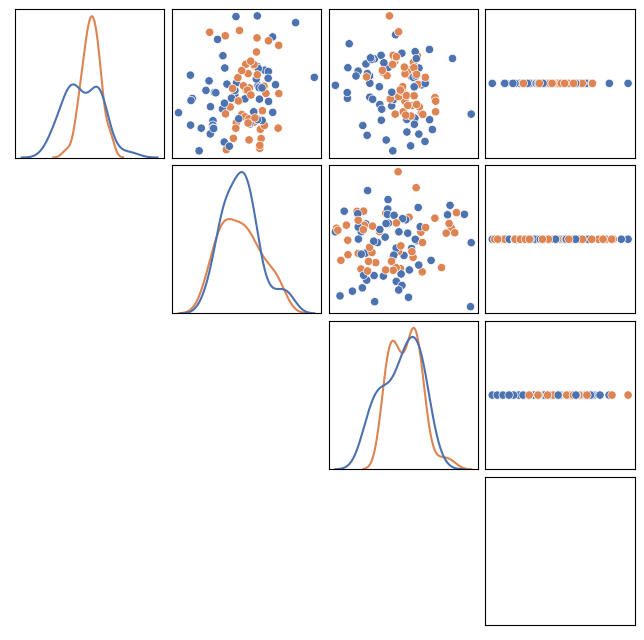

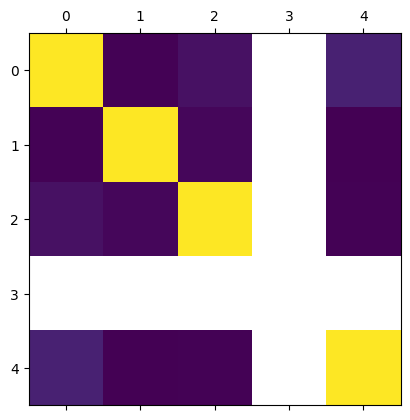

In [56]:
import traceback
try:
    config_sample['batch_size'] = 1
    model = get_model(config_sample, device, should_train=False, verbose=2) # , state_dict=model[2].state_dict()
    (hp_embedding, data, _), targets, single_eval_pos = next(iter(model[3]))
    print(data.shape)
    print("target")
    print(targets)
    from utils import normalize_data
    fig = plt.figure(figsize=(8, 8))
    N = 100
    plot_features(data[0:N, 0, 0:4], targets[0:N, 0], fig=fig)

    d = np.concatenate([data[:, 0, :].T.cpu(), np.expand_dims(targets[:, 0].cpu(), -1).T])
    d[np.isnan(d)] = 0
    c = np.corrcoef(d)
    plt.matshow(np.abs(c), vmin=0, vmax=1)
    plt.show()
except:
    traceback.print_exc()

## Training

In [12]:
import traceback
try:
    model = get_model(config_sample, device, should_train=True, verbose=1)
except:
    traceback.print_exc()


Using style prior: True
{'recompute_attn': True}
<module 'wandb' from '/home/parietal/lgrinszt/.local/miniconda3/envs/tab_pfn/lib/python3.9/site-packages/wandb/__init__.py'>
Using cuda:2 device
Using a Transformer with 25.77 M parameters
Batch loss:  2.3538882732391357
Batch 0 took 0.08s to process, 0.02s to get batch, 0.04s to forward
Batch loss:  2.4615259170532227
Batch 20 took 0.06s to process, 0.02s to get batch, 0.02s to forward
Batch loss:  2.346018075942993
Batch 40 took 0.05s to process, 0.02s to get batch, 0.02s to forward
Batch loss:  2.4450488090515137
Batch 60 took 0.06s to process, 0.02s to get batch, 0.02s to forward
Epoch Loss 2.375678062438965
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  5.58s | mean loss  2.38 | pos losses   nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, 2.34,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  